No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(402, 7)
   USE     RS        RS_ALT           GEN     SHAPE_LENG    SHAPE_AREA  \
0    4  01001  010010000000     Flensburg   32467.034276  5.324899e+07   
1    4  01002  010020000000          Kiel   73027.302434  1.218654e+08   
2    4  01003  010030000000        Lübeck  104861.094220  2.211386e+08   
3    4  01004  010040000000    Neumünster   39858.818376  8.092363e+07   
4    4  01051  010510000000  Dithmarschen  202206.675707  1.450311e+09   

                                            geometry  
0  POLYGON ((9.48982 54.82296, 9.50467 54.81004, ...  
1  POLYGON ((10.19057 54.38909, 10.18370 54.38910...  
2  POLYGON ((10.89297 53.95695, 10.90337 53.95705...  
3  POLYGON ((10.03454 54.12915, 10.02277 54.10938...  
4  MULTIPOLYGON (((9.05176 54.36640, 9.07193 54.3...  


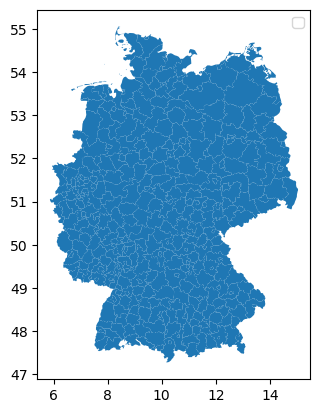

In [54]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
import geopandas as gpd
influenza_df = pd.read_csv("Influenza.csv", sep=',')
df = gpd.read_file('vg2500_krs.shp')

df.head()
df = df.set_geometry('geometry')

print(df.shape)
locations = influenza_df.location.unique()
print(df.head())
#df.plot(label=df["GEN"])  
df.plot(label=df["GEN"])
plt.legend()

In [55]:
namen = list(df["GEN"])
umbenennung = dict()
for name in namen:
    for location in locations:
        if name in location:
            df.loc[df.GEN == name, 'location'] = location
        
#print(df)
df['location'] = df['location'].fillna(df.GEN)
print(list(df.location))

['SK Flensburg', 'SK Kiel', 'SK Lübeck', 'SK Neumünster', 'LK Dithmarschen', 'LK Herzogtum Lauenburg', 'LK Nordfriesland', 'LK Ostholstein', 'LK Plön', 'LK Rendsburg-Eckernförde', 'LK Schleswig-Flensburg', 'LK Segeberg', 'LK Steinburg', 'LK Stormarn', 'SK Hamburg', 'SK Braunschweig', 'SK Salzgitter', 'SK Wolfsburg', 'LK Gifhorn', 'LK Göttingen', 'LK Goslar', 'LK Helmstedt', 'LK Northeim', 'Osterode am Harz', 'LK Peine', 'LK Wolfenbüttel', 'Region Hannover', 'LK Diepholz', 'LK Hameln-Pyrmont', 'LK Hildesheim', 'LK Holzminden', 'LK Pinneberg', 'LK Nienburg (Weser)', 'LK Schaumburg', 'LK Celle', 'LK Cuxhaven', 'LK Harburg', 'LK Lüchow-Dannenberg', 'LK Lüneburg', 'LK Osterholz', 'LK Rotenburg (Wümme)', 'LK Heidekreis', 'LK Stade', 'LK Uelzen', 'LK Verden', 'SK Delmenhorst', 'SK Emden', 'Oldenburg (Oldenburg)', 'SK Osnabrück', 'SK Wilhelmshaven', 'LK Ammerland', 'LK Aurich', 'LK Cloppenburg', 'LK Emsland', 'LK Friesland', 'LK Grafschaft Bentheim', 'LK Leer', 'LK Oldenburg', 'SK Osnabrück', 

/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() 

LK Alb-Donau-Kreis
[['LK Göppingen', 'LK Heidenheim', 'LK Reutlingen', 'LK Neu-Ulm', 'LK Biberach', 'LK Günzburg', 'LK Neu-Ulm']]
LK Altenkirchen
[]
LK Alzey-Worms
[['LK Bergstraße', 'LK Groß-Gerau', 'LK Bad Kreuznach', 'SK Worms', 'LK Bad Dürkheim', 'LK Donnersbergkreis', 'LK Mainz-Bingen']]
LK Amberg-Sulzbach


/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() 

[['SK Amberg', 'Neumarkt i.d. OPf.', 'Neustadt a.d. Waldnaab', 'LK Schwandorf', 'LK Bayreuth', 'LK Nürnberger Land']]
LK Ansbach
[]
LK Aurich
[['SK Emden', 'LK Leer', 'LK Wittmund']]
LK Bad Dürkheim
[['SK Kaiserslautern', 'Landau in der Pfalz', 'Neustadt an der Weinstraße', 'SK Worms', 'LK Alzey-Worms', 'LK Donnersbergkreis', 'SK Kaiserslautern', 'LK Südliche Weinstraße', 'LK Rhein-Pfalz-Kreis', 'LK Südwestpfalz']]


/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument

LK Bad Kissingen
[['LK Main-Kinzig-Kreis', 'LK Fulda', 'LK Rhön-Grabfeld', 'LK Main-Spessart', 'SK Schweinfurt']]
LK Bad Kreuznach
[['LK Birkenfeld', 'LK Rhein-Hunsrück-Kreis', 'LK Alzey-Worms', 'LK Donnersbergkreis', 'LK Kusel', 'LK Mainz-Bingen']]
LK Bamberg
[]


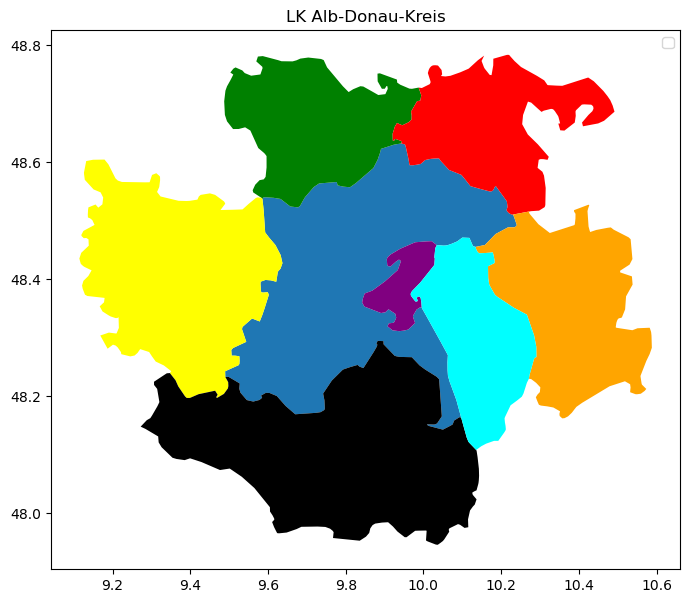

ValueError: cannot convert float NaN to integer

<Figure size 1000x700 with 1 Axes>

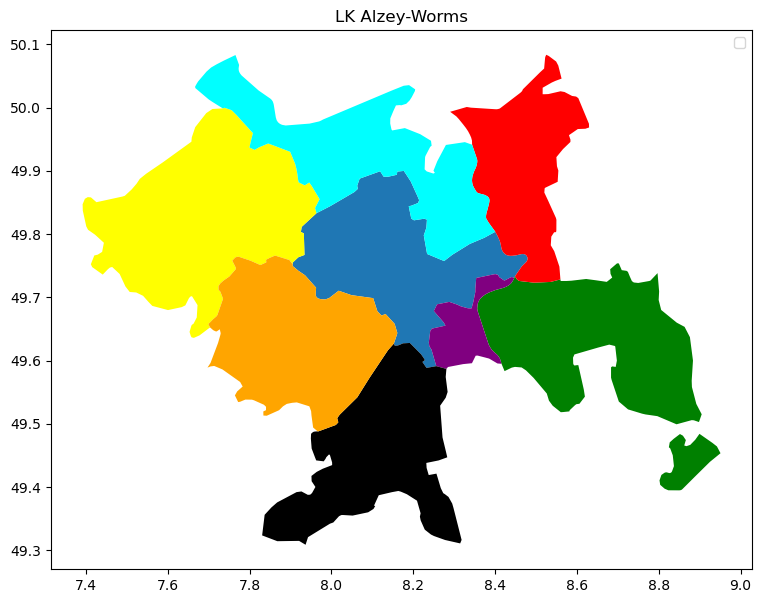

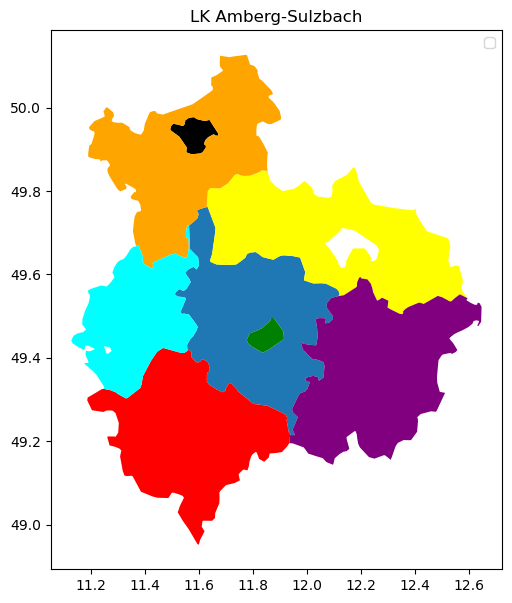

ValueError: cannot convert float NaN to integer

<Figure size 1000x700 with 1 Axes>

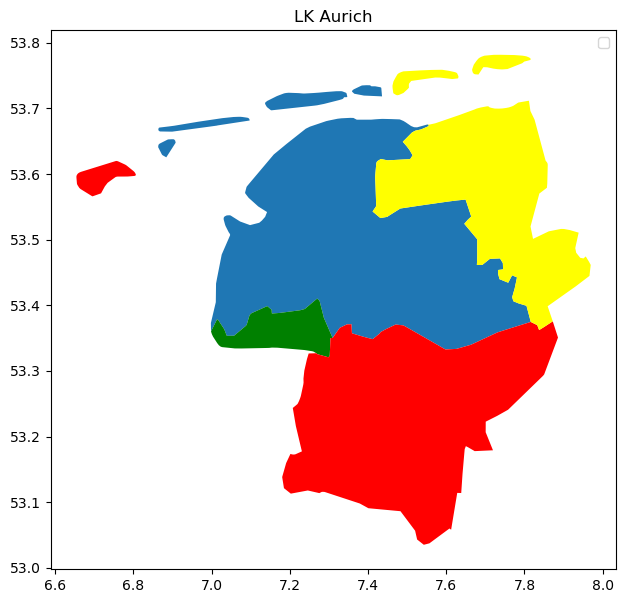

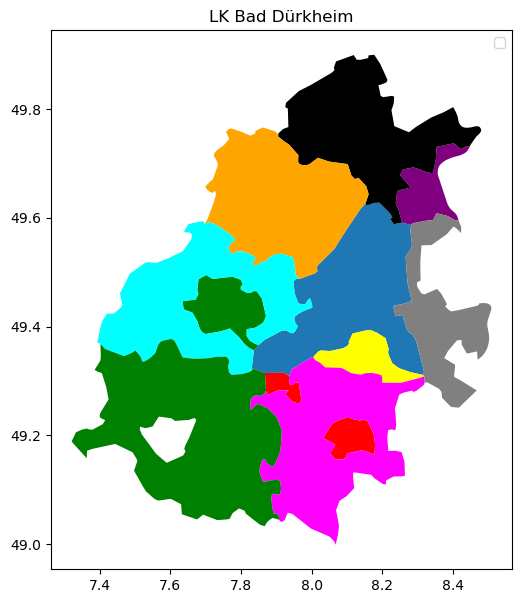

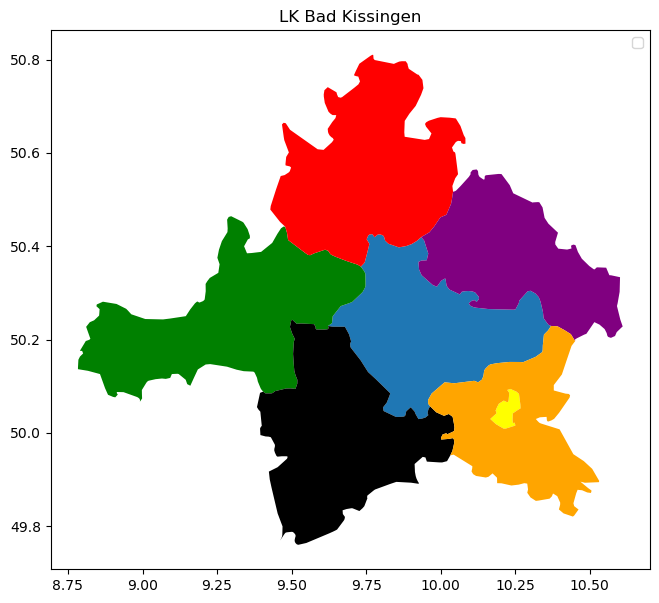

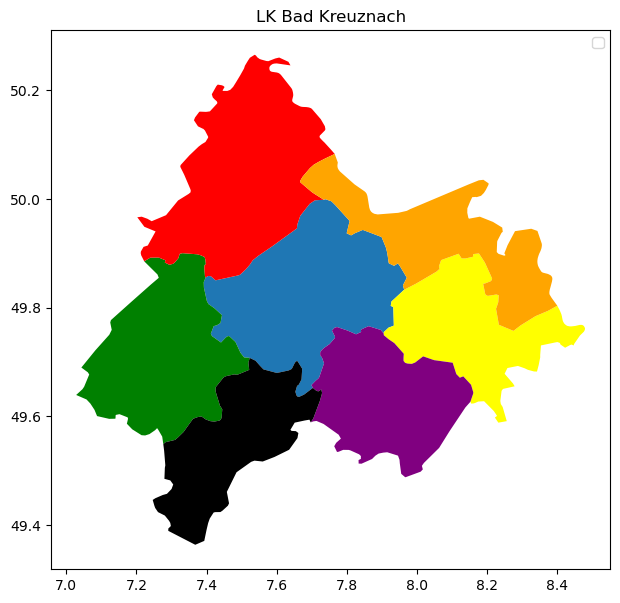

ValueError: cannot convert float NaN to integer

<Figure size 1000x700 with 1 Axes>

In [81]:
for index, row in df.iterrows():  
    neighbors = df[df.geometry.touches(row['geometry'])].location.tolist() 
    #print(neighbors)
    if row.location in neighbors:   
        neighbors = neighbors.remove(row.location)
    if neighbors is not None:
        df.at[index, "my_neighbors"] = neighbors#", ".join(neighbors)
    #else: 
     #   print(f"NONE für {row.location}")
#print(neighbors)

colors = ["green", "red", "yellow" , "purple", "black", "orange", "cyan", "magenta", "grey"]*2
for location in locations[:10]:
    print(location)
    location_df = df.loc[df.location == location].copy()
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    location_df.plot(ax=ax)
    plt.title(f"{location}")
    neighbors = list(location_df["my_neighbors"])
    print(neighbors)
    if len(neighbors) >0:
        for neighbor in neighbors:
            neighbor_df = df.loc[df.location.isin(neighbor)].copy()
            neighbor_df.plot(neighbor_df, ax=ax, color=colors, legend=True)
    plt.legend()
plt.show()

In [3]:
import networkx as nx
G=nx.read_shp('vg2500_krs.shp')
A = nx.adjacency_matrix(G)
nx.draw(G)

/tmp/ipykernel_3233094/2454485833.py:2: DeprecationWarning: read_shp is deprecated and will be removed in 3.0.See https://networkx.org/documentation/latest/auto_examples/index.html#geospatial.
  G=nx.read_shp('vg2500_krs.shp')


ImportError: read_shp requires OGR: http://www.gdal.org/

,geometry
0,"POLYGON ((9.48982 54.82296, 9.50467 54.81004, ..."
1,"POLYGON ((10.19057 54.38909, 10.18370 54.38910..."
2,"POLYGON ((10.89297 53.95695, 10.90337 53.95705..."
3,"POLYGON ((10.03454 54.12915, 10.02277 54.10938..."
4,"MULTIPOLYGON (((9.05176 54.36640, 9.07193 54.3..."
...,...
397,"POLYGON ((11.42397 50.80862, 11.42072 50.80306..."
398,"POLYGON ((12.01807 50.96757, 12.02085 50.94806..."
399,"POLYGON ((11.94482 50.59236, 11.92423 50.58608..."
400,"POLYGON ((12.22219 50.94284, 12.23787 50.92905..."
